# Modeling a theoretical co-culture of perchlorate-reducing bacteria and chlorate-reducing bacteria

This Jupyter Notebook is a supplement to the manuscript Barnum et. al 2019.

Reduction of perchlorate by bacteria involves the respiration of several high-energy substrates in multiple steps: perchlorate is reduced to chlorate, chlorate is reduced to chlorite, chlorite is converted to chloride and oxygen (without energy conservation), and oxygen is reduced to water. Chlorate accumulates to varying levels during perchlorate reduction because one enzyme (perchlorate reductase, or Pcr)  reduces both perchlorate and chlorate (Dudley et. al 2008). Substrate inhibition of perchlorate reductase at high concentrations of perchlorate (>1 mM) may also contribute (Youngblut et. al 2016). Accumulaton of chlorite or oxygen has not been observed.

In the present study, we found that chlorate-reducing bacteria (CRB), which cannot reduce perchlorate to chlorate, can dominate cultures of perchlorate-reducing bacteria (PRB) in a metabolic interaction based on the exchange of chlorate.

To understand this interaction, we present models to simulate the behavior of the interaction *in silico*. We chose a model based on an approximation of Michaelis-Menton kinetics known as Equilibrium Chemistry Approximation (ECA). Other models, a simple Michaelis-Menton kinetics model and a Michaelis-Menton kinetics model including competitive inhibition (Dudley et. al 2008), are included for comparison. The Equilibrium Chemistry Approximation model allows the inclusion of the following features:

- Competition of chlorate and perchlorate for Pcr following diffusion of chlorate from the active site
- Competition for the reduction of chlorate to chloride by either the perchlorate reducer or chlorate reducer
- Competition for acetate as a source of electrons and carbon
- Substrate inhibition of Pcr by perchlorate (IGNORED HERE)

The code uses the following data:

- The half-velocity constant (Ks) of Pcr for chlorate and perchlorate, from Youngblut et. al 2016a
- Redox potential of perchlorate/chlorate, from Youngblut et. al 2016b
- Redox potential of chlorate/chloride adjusted to reflect the perchlorate reduction pathway, from Youngblut et. al 2016b

Scripts required to run this code:

- energetics.py -- Equations for calculating yield, stoichiometry              
- kinetics.py -- Equations for kinetics models
- perchlorate_reduction_models.py -- Formulations of models specific to perchlorate reduction using energetics.py and kinetics.py

### Load Functions

In [1]:
# Custom functions and variables

import sys
sys.path.append('./scripts') # Location of modules
from perchlorate_reduction_models import * 

In [2]:
# External packages

# Integration function
from scipy.integrate import odeint 

# Data wrangling
import numpy as np
import pandas as pd
from pylab import *

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; 
sns.set(style='ticks',palette='Set2') # Tufte and Brewer style
sns.despine()
plt.rcParams['svg.fonttype'] = 'none' # Editable SVG text
%matplotlib inline

In [15]:
# Functions for resetting values and assisting plotting and data interpretation

def reset_parameters():

    # All concentrations in molarity (M)
    
    # Substrate affinity [PRB,CRB], Ks (M) 
    ks_clo4 = np.array([0.0060,10000])*10**-3 # Ks perchlorate, 0.0019 (Dudley) super high value for CRB because it does not catalyze
    ks_clo3 = np.array([0.0074,0.0074])*10**-3 # Ks chorate  0.0007 M - Dudley #0.159 CRB
    #ks_clo3 = np.array([0.0074,0.159])*10**-3 # Ks chorate  0.0007 M - Dudley #0.159 CRB
    ks_acet = np.array([1,1])*10**-3 # Ks acetate

    # Substrate inhibition factor, Haldane kinetics [PRB,CRB], Ki (M)
    # Inhibition only occurs for PRB with perchlorate
    # Youngblut et. al 2016 http://www.jbc.org/content/291/17/9190.full.pdf
    ki_clo4 = np.array([10000, 10000])*10**-3   # Ki perchlorate, only low for ClO4- and PRB
    #ki_clo4 = np.array([7.5, 10000])*10**-3   # Ki perchlorate, only low for ClO4- and PRB
    ki_clo3 = np.array([10000, 10000])*10**-3   # Ki chlorate
    ki_acet = np.array([10000, 10000])*10**-3   # Ki acetate

    # Growth and death rate
    mu = np.array([0.5,0.5]) # Maximum growth rate
    m = np.array([0.0,0.0])# Death rate

    return ks_clo4, ks_clo3, ks_acet, ki_clo4, ki_clo3, ki_acet, mu, m


def reset_default_concentrations():

    # Initial concentrations (M)
    x0 = [0.00001, # PRB 
          0.00001, # CRB 
          0.015, # Acetate
          0.01, # Perchlorate
          0.0, # Chlorate
          0.0,# Cum. clorate to PRB
          0.0]# Cum. clorate to CRB

    return x0

# Format a dataframe from ODE output
def odeint_to_dataframe(state):

    df = pd.DataFrame(state)
    df.columns = values[0:7] # "PRB","CRB","C2H3O2-","ClO4-","ClO3-", "ClO3- to PRB", "ClO3- to CRB"

    df[time] = t_span # Time
    df["CRB"] = df["CRB"] * 113 # 113 g / mol biomass (C5H7O2N)
    df["PRB"] = df["PRB"] * 113 # 113 g / mol biomass (C5H7O2N)
    df["CRB/PRB"] = df["CRB"] / df["PRB"] # Ratio
    df["Total Cells"] = df["CRB"] + df["PRB"] # Sum
    df["CRB Growth Rate"] = df["CRB"].diff() / df[time].diff() # Ratio
    df["PRB Growth Rate"] = df["PRB"].diff() / df[time].diff() # Ratio
    df["Cumulative fClO3- CRB"] = df["ClO3- to CRB"] / (df["ClO3- to CRB"] + df["ClO3- to PRB"])
    df["fClO3- CRB"] = df["ClO3- to CRB"].diff() / (df["ClO3- to CRB"].diff() + df["ClO3- to PRB"].diff())
    df["ClO3-:ClO4-"] = df["ClO3-"] / df["ClO4-"]
    df["ClO4-:ClO3-"] = df["ClO4-"] / df["ClO3-"]

    return df

# Summarize different attributes of the dataframe
def dataframe_statistics(df):

    statistics = {"Max. ClO3-" : max(df['ClO3-']),
                  "Max. ClO4-" : max(df['ClO4-']),
                  "Max. CRB" : max(df['CRB']),
                  "Max. PRB" : max(df['PRB']),
                  "Max. Total Cells" : max(df["Total Cells"]),
                  "Max. CRB/PRB" : max(df["CRB/PRB"]),
                  "% ClO3- to CRB" : 100 * max(df["ClO3- to CRB"] / (x0[id_clo4] + x0[id_clo3])),
                  "f:CRB/PRB" : df["CRB/PRB"].tolist()[-1],
                  "f:CRB/PRB / i:CRB/PRB" : df["CRB/PRB"].tolist()[-1] / df["CRB/PRB"].tolist()[0],
                  "Max. ClO4- Reduction Rate (M/h)" : max(abs(df['ClO4-'].diff().fillna(0))),
                 }

    return statistics


def plot_growth_curves(df,plot_title='',save_to_file=None):

    # Plot
    values_to_plot = ["PRB","CRB","C2H3O2-","ClO4-","ClO3-", "ClO3- to PRB", "ClO3- to CRB", time]
    colors = ['#D65228','#E69C26','black','#D65228','#E69C26','#D65228','#E69C26']
    linestyles = ['-','-',':',':',':','--','--']

    fig, (ax0,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(6,9), gridspec_kw = {'height_ratios':[10,4,4,4]})
    ax0.set_title(plot_title, size=13)
    
    ax1 = ax0.twinx()

    ax=ax0
    ax.set_ylabel('Biomass (g/L)')
    df.loc[:,["PRB","CRB", time]].plot(ax=ax,x=time, color=['#D65228','#E69C26'], style=['-','-'])
    ax.legend(loc='center right')

    ax=ax1
    ax.set_ylabel('Concentration (M)')
    df.loc[:,["C2H3O2-","ClO4-","ClO3-", time]].plot(ax=ax,x=time, color=['black','black','black'], style=[':','-','--']) 
    ax.legend(loc='lower right')

    ax=ax2
    df.loc[:,[time,"ClO3-:ClO4-"]].plot(ax=ax,x=time,color='black',legend=None)
    ax.set_ylabel("[ClO3-] / [ClO4-]")

    ax=ax3
    df.loc[:,[time,"fClO3- CRB"]].plot(ax=ax,x=time,color='black',legend=None)
    ax.set_ylabel("Fraction ClO3- to CRB")
    ax.set_ylim([0,1])

    ax=ax4
    df.loc[:,[time,"CRB Growth Rate","PRB Growth Rate"]].plot(ax=ax,x=time,color=['#E69C26','#D65228'],legend=None)
    ax.set_ylabel("Growth Rate (g L-1 h-1)")

    # Formatting
    
    for ax in (ax0,ax1,ax2,ax3,ax4):
        ax.spines["top"].set_visible(False)
        ax.xaxis.set_ticks_position('bottom') 

    for ax in (ax2,ax3,ax4):
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_ticks_position('left') 

    for ax in (ax2,ax3):
        ax.set_xlabel("")
        ax.xaxis.set_ticks_position('none') 
        for xlabel_i in ax.axes.get_xticklabels():
            xlabel_i.set_visible(False)
            xlabel_i.set_fontsize(0.0)
            
    if save_to_file == None:
        pass
    else:
        plt.savefig('./data/' + save_to_file)
            
    return plt.show()

## Model Input

In [13]:
# Energetics of 
energy = pd.DataFrame({"Electron acceptor half-reaction" : ["Gr", "A", "fs", "fe"],
                      "O2/H2O": energy_to_fractions(-78.72),
                      "NO3-/N2": energy_to_fractions(-72.20),
                      "SO42-/HS-": energy_to_fractions(20.85),
                      "CO2/CH4": energy_to_fractions(23.53),
                      "ClO4-/ClO3-" : energy_to_fractions(redox_to_Ga(ne_perc,E_perc)),
                      "ClO3-/Cl-": energy_to_fractions(redox_to_Ga(ne_chlor,E_chlor)),
                      })

energy = energy.set_index("Electron acceptor half-reaction")
energy = energy.transpose()

# save to CSV
energy.to_csv('./data/energetics.csv')

energy.sort_values(by='A')

Electron acceptor half-reaction,Gr,A,fs,fe
O2/H2O,-106.12000,2.037739,0.329192,0.670808
ClO4-/ClO3-,-105.83824,2.043164,0.328605,0.671395
ClO3-/Cl-,-103.81216,2.083040,0.324355,0.675645
NO3-/N2,-99.60000,2.171134,0.315345,0.684655
SO42-/HS-,-6.55000,33.014488,0.029399,0.970601
CO2/CH4,-3.87000,55.877235,0.017582,0.982418


<b>Above Table: </b> Energetic properties of different electron acceptors. Gr,  energy per equiv. oxidized for energy production; A, equivalents of donor used for energy per cells formed; fs, fraction of donor used for cell synthesis; fe, fraction of donor used for energy.

In [14]:
df = pd.DataFrame({"Population" : ['Perchlorate-reducing bacteria (PRB)', 'Chlorate-reducing bacteria (CRB)'],
                   "Ks ClO4- (M)" : ks_clo4,
                   "Ks ClO3- (M)" : ks_clo3,
                   "Ks C2H3O2- (M)" : ks_acet,
                   "Ki ClO4- (M)" : ki_clo4,
                   "Ki ClO3- (M)" : ki_clo3,
                   "Ki C2H3O2- (M)" : ki_acet,
                   "Maximum growth rate (h^-1)" : mu,
                   "Death rate (h^-1)" : m,
                   "Yield coefficient ClO4- to ClO3-" : ypc,
                   "Yield coefficient ClO3- to Cl-" : yc,
                   "Stoichiometric ratio ClO4- to ClO3-" : ypa,
                   "Stoichiometric ratio ClO3- to Cl-" : yca,
                  })

df = df.set_index("Population")
df = df.transpose()

# save to CSV
df.to_csv('./data/model-input.csv')
df

Population,Perchlorate-reducing bacteria (PRB),Chlorate-reducing bacteria (CRB)
Ks ClO4- (M),0.000006,10.000000
Ks ClO3- (M),0.000007,0.000007
Ks C2H3O2- (M),0.001000,0.001000
Ki ClO4- (M),10.000000,10.000000
Ki ClO3- (M),10.000000,10.000000
Ki C2H3O2- (M),10.000000,10.000000
Maximum growth rate (h^-1),0.500000,0.500000
Death rate (h^-1),0.000000,0.000000
Yield coefficient ClO4- to ClO3-,0.048944,0.000000
Yield coefficient ClO3- to Cl-,0.144017,0.144017


<b>Above Table: </b> Model parameters for each population

## Model Simulations 

### Equilibrium Chemistry Approximation (ECA) kinetics

The Equilibrium Chemistry Approximation (ECA) of Michaelis-Menton kinetics includes competitive inhibition for Pcr and competition for substrates.

#### PRB Only

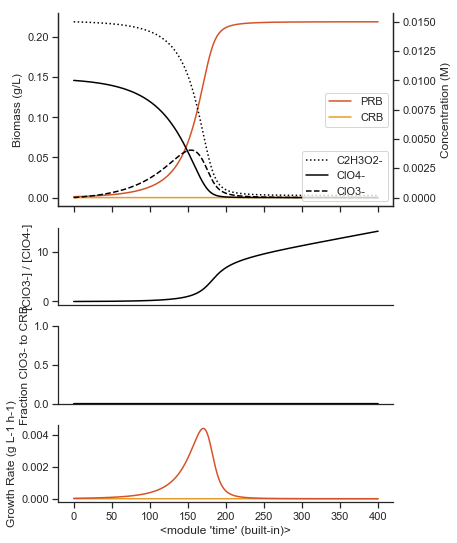

In [19]:
ks_clo4, ks_clo3, ks_acet, ki_clo4, ki_clo3, ki_acet, mu, m = reset_parameters()

# Initial concentrations (M), with no CRB
x0 = reset_default_concentrations()
x0[id_crb] = 0

# Time steps
t_end = 400; # end time (hours)
dt = 0.1; # time step (hours)
t_span = np.arange(0,t_end,dt)

# Run ECA kinetics model and plot
state = odeint(eca_kinetics, x0, t_span)
df = odeint_to_dataframe(state)
plot_growth_curves(df,save_to_file='eca-prb-only.png')

#### PRB + CRB

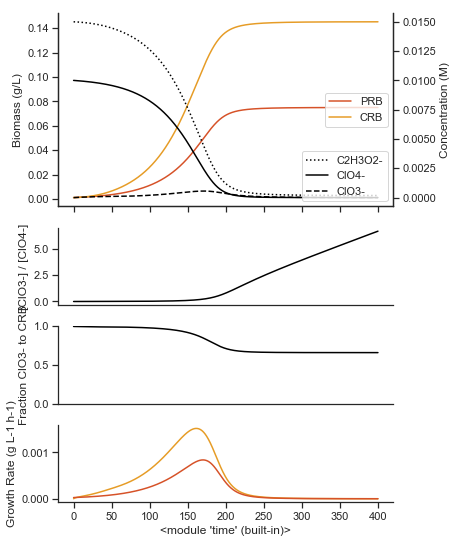

In [20]:
# CRB concentration = PRB concentration
x0[id_crb] = x0[id_prb]

state = odeint(eca_kinetics, x0, t_span)
df = odeint_to_dataframe(state)
plot_growth_curves(df,save_to_file='eca-prb-and-crb.png')

### Results

*Without* chlorate-reducing bacteria:

- Chlorate (dashed line) accumulates during perchlorate reduction
- Growth rate of the perchlorate-reducing population peaks when chlorate reduction begins

*With* chlorate-reducing bacteria present:
- Chlorate concentration decreases
- Chlorate-reducing bacteria dominate the culture
- Chlorate-reducing bacteria consume nearly all chlorate while fraction of chlorate is low
- Chlorate-reducing bacteria have a higher growth rate throughout growth

### Conclusions

- Chlorate-reducing bacteria utilize chlorate when perchlorate-reducing bacteria cannot: when the concentration of chlorate relative to perchlorate is low
- Beacuse chlorate reduction to chloride has a higher total yield than perchlorate reduction to chlorate, chlorate-reducing bacteria have a higher growth rate
- The consumption of chlorate by chlorate-reducing bacteria maintains the low chlorate:perchlorate ratio conducive to their success


## Other Model Simulations for Comparison


### Michaelis-Menton (MM) kinetics

Simple model for growth limited by substrate concentrations

#### PRB Only

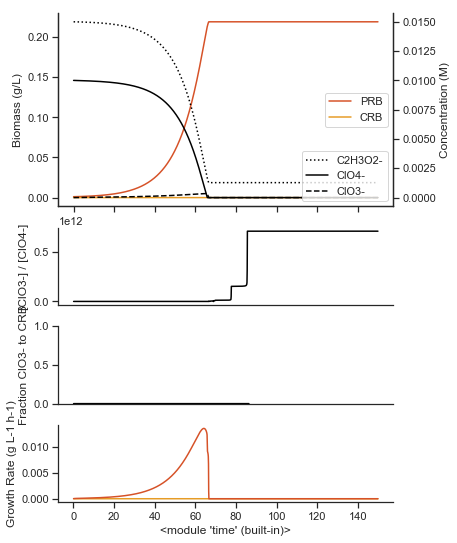

In [21]:
# No CRB
x0[id_crb] = 0

# Time steps
t_end = 150; # end time (hours)
dt = 0.1; # time step (hours)
t_span = np.arange(0,t_end,0.1)

# Run Michaelis-Menton kinetics and plot simulation
state = odeint(mm_kinetics, x0, t_span)
df = odeint_to_dataframe(state)
plot_growth_curves(df,save_to_file='mm-prb-only.png')

#### PRB + CRB

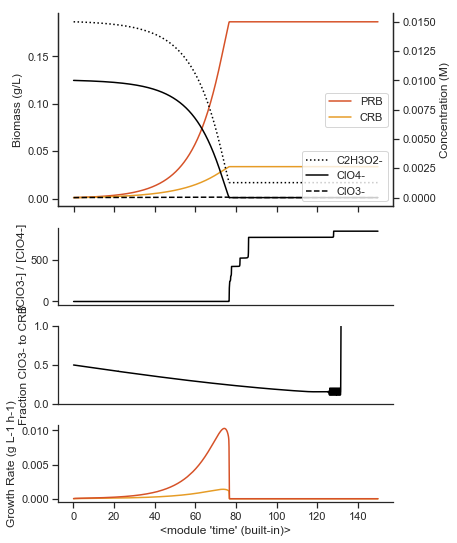

In [22]:
# CRB concentration = PRB concentration
x0[id_crb] = x0[id_prb]

# Run Michaelis-Menton kinetics and plot simulation
state = odeint(mm_kinetics, x0, t_span)
df = odeint_to_dataframe(state)
plot_growth_curves(df,save_to_file='mm-prb-and-crb.png')

### Michaelis-Menton kinetics with competitive inhibition (CI) (Dudley et. al 2008)

Accounts for the consumption of perchlorate and chlorate by the same cell

#### PRB Only

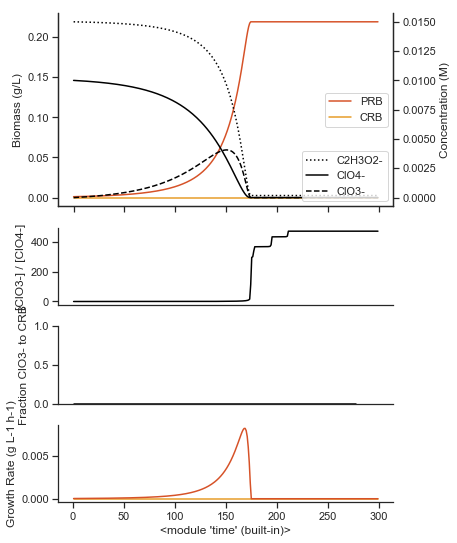

In [23]:
# Initial concentrations (M)
x0[id_crb] = 0

# Time steps
t_end = 300; # end time (hours)
dt = 1; # time step (hours)
t_span = np.arange(0,t_end,dt)

# Run competitive inhibition model and plot simulation
state = odeint(ci_kinetics, x0, t_span)
df = odeint_to_dataframe(state)
plot_growth_curves(df,save_to_file='ci-prb-only.png')

#### PRB + CRB

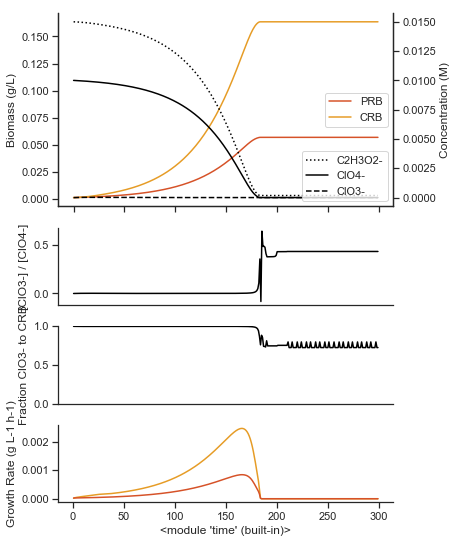

In [24]:
# CRB concentration = PRB concentration
x0[id_crb] = x0[id_prb]

state = odeint(ci_kinetics, x0, t_span)
df = odeint_to_dataframe(state)
plot_growth_curves(df, save_to_file='ci-prb-and-crb.png')

### Results

- Michaelis-Menton kinetics with competitive inhibition of Pcr by chlorate produces similar results to the ECA kinetics model and live co-cultures
- The model without competitive inhibition of Pcr by chlorate shows little chlorate accumulation and much less CRB growth

### Conclusions

- Competitive inhibition is an important component of the model to recapitulate experimental behavior

## Effect of varying initial concentrations on the interaction

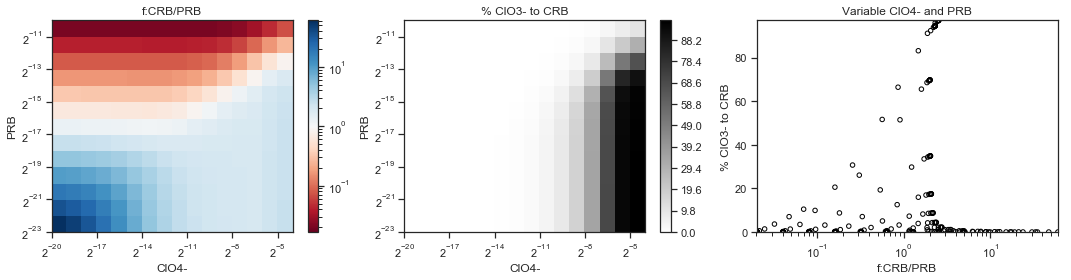

In [26]:
def correlate_two_z_variables(id_N1,id_N2,z1_variable,z2_variable,save_to_file=None):

    import matplotlib.colors as colors
    
    fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(15,4))

    Z1 = np.array(x_range)
    Z2 = np.array(x_range)
    
    z_variable = [z1_variable, z2_variable]
    z_scale = [z1_scale,z2_scale]
    Z = [Z1,Z2]
    axes = [ax0,ax1]
    color_map = [z1_color_map,z2_color_map]
    
    for N in [0,1]:
    
        # Initialize X-, Y-, and Z- dimensions
        X = np.array(x_range)
        Y = np.array(x_range)

        for y in y_range:

            output = []

            # Plot by varying concentration
            for x in x_range:

                # Initial values
                x0 = reset_default_concentrations()

                # Replace one initial condition with x, a varying value
                x0[id_N1] = x
                x0[id_N2] = y

                # Calculate from each initial condition
                state = odeint(eca_kinetics, x0, t_span)
                df = odeint_to_dataframe(state)
                statistics = dataframe_statistics(df)
                output.append(statistics[z_variable[N]])

            x_row = x_range
            X = np.vstack((X,x_row))

            y_row = np.array([y]*len(x_range))
            Y = np.vstack((Y,y_row))

            z_row = output
            Z[N] = np.vstack((Z[N],z_row))

        X = X[1:] # X-dimension
        Y = Y[1:] # Y-dimension
        #Z[N] = Z[N][1:] # Z-dimension
        Z[N] = Z[N][1:-1, :-1] # Z-dimension within X-Y bounds

        # Plot each heatmap
        
        # Normalization
        cmap = plt.get_cmap(color_map[N])
        levels = MaxNLocator(nbins=1000).tick_values(Z[N].min(), Z[N].max())

        if z_scale[N] == 'log':
            # https://matplotlib.org/users/colormapnorms.html
            if (z_variable[N] == 'f:CRB/PRB') | (z_variable[N] == "f:CRB/PRB / i:CRB/PRB"):
                z_bound = np.max([1/Z[N].min(),Z[N].max()])
                norm = colors.LogNorm(vmin=1/z_bound, vmax=z_bound)
            else:
                norm = colors.LogNorm(vmin=Z[N].min(), vmax=Z[N].max())
        else:
            # https://matplotlib.org/api/_as_gen/matplotlib.colors.BoundaryNorm.html
            norm = colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        """if z_scale == 'log':
            # https://matplotlib.org/users/colormapnorms.html
            norm = colors.LogNorm(vmin=Z[N].min(), vmax=Z[N].max())
        else:
            # https://matplotlib.org/api/_as_gen/matplotlib.colors.BoundaryNorm.html
            norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)"""

        im = axes[N].pcolormesh(X, Y, Z[N], cmap=cmap, norm=norm)
        fig.colorbar(im, ax=axes[N])

        axes[N].set_xscale(x_scale, basex=2)
        axes[N].set_yscale(y_scale, basey=2)
        axes[N].set_title(z_variable[N])
        axes[N].set_xlabel(values[id_N1])
        axes[N].set_ylabel(values[id_N2])

        plt.tight_layout()
    
    # Plot correlation
    
    Z1 = Z[0]
    Z2 = Z[1]
    
    ax2.scatter(x=Z1,y=Z2, s=20,  facecolor="None", edgecolors='black', linewidths=1,)

    ax2.set_xscale(z1_scale)
    ax2.set_yscale(z2_scale)
    ax2.set_xlim([Z1.min(),Z1.max()])
    ax2.set_ylim([Z2.min(),Z2.max()])
    ax2.set_xlabel(z1_variable)
    ax2.set_ylabel(z2_variable)
    ax2.set_title("Variable "+values[x_variable]+" and "+values[y_variable])
    
    if save_to_file == None:
        pass
    else:
        plt.savefig('./data/' + save_to_file)
    
    return plt.show()

# Reset values
ks_clo4, ks_clo3, ks_acet, ki_clo4, ki_clo3, ki_acet, mu, m = reset_parameters()
x0 = reset_default_concentrations()

# Longer time period to capture all growth
t_end = 5000; # end time (hours)
dt = 1; # time step (hours)
t_span = np.arange(0,t_end,5)

# Z1 (X):  ratio
z1_variable = "f:CRB/PRB"
z1_scale = 'log'
z1_color_map = 'RdBu'

# Z2 (Y): Max. ClO4- Reduction Rate (M/h)
z2_variable = "% ClO3- to CRB"
z2_scale = 'linear'
z2_color_map = 'binary'

# Y: PRB concentration steps
y_variable = id_prb
y_base2_min  = -23
y_base2_max  = -10
y_base2_steps = 1 + y_base2_max - y_base2_min
y_range = np.logspace(start=y_base2_min,stop=y_base2_max,base=2,num=y_base2_steps)
y_scale = 'log'

# X: Perchlorate concentration steps
x_variable = id_clo4
x_base2_min  = -20
x_base2_max  = -4
x_base2_steps = 1 + x_base2_max - x_base2_min
x_range = np.logspace(start=x_base2_min,stop=x_base2_max,base=2,num=x_base2_steps)
x_scale = 'log'

correlate_two_z_variables(x_variable,y_variable,z1_variable,z2_variable,save_to_file="corr-prb-perc-ratio-chlor.svg")

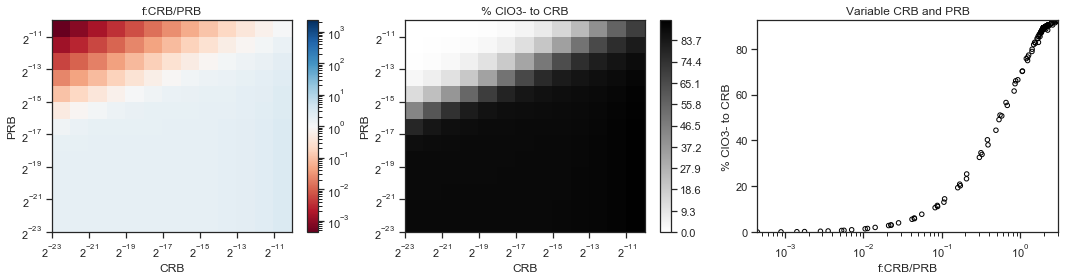

In [27]:
# Reset values
ks_clo4, ks_clo3, ks_acet, ki_clo4, ki_clo3, ki_acet, mu, m = reset_parameters()
x0 = reset_default_concentrations()

# Z1 (X): Final ratio
z1_variable = "f:CRB/PRB"
z1_scale = 'log'
color_map = 'RdBu'

# Z2 (Y): Max. ClO4- Reduction Rate (M/h)
z2_variable = "% ClO3- to CRB"
z2_scale = 'linear'
z2_color_map = 'binary'

# Y: PRB
y_variable = id_prb
y_base2_min  = -23
y_base2_max  = -10
y_base2_steps = 1 + y_base2_max - y_base2_min
y_range = np.logspace(start=y_base2_min,stop=y_base2_max,base=2,num=y_base2_steps)
y_scale = 'log'

# X: CRB
x_variable = id_crb
x_base2_min  = -23
x_base2_max  = -10
x_base2_steps = 1 + x_base2_max - x_base2_min
x_range = np.logspace(start=x_base2_min,stop=x_base2_max,base=2,num=x_base2_steps)
x_scale = 'log'

correlate_two_z_variables(x_variable,y_variable,z1_variable,z2_variable, "corr-prb-crb-ratio-chlor.svg")

In [28]:
print('Other z-dimensions available to plot:')
statistics = dataframe_statistics(df)
for stat in statistics.keys():
    print (stat, "\t")

Other z-dimensions available to plot:
Max. ClO3- 	
Max. ClO4- 	
Max. CRB 	
Max. PRB 	
Max. Total Cells 	
Max. CRB/PRB 	
% ClO3- to CRB 	
f:CRB/PRB 	
f:CRB/PRB / i:CRB/PRB 	
Max. ClO4- Reduction Rate (M/h) 	


### Results and Conclusions

- CRB were successful than PRB across a very wide range of initial concentrations.
- CRB were most successful at high concentrations of perchlorate.